## HWO and Galaxy Transformation

This notebook implements a science case for HWO in DISRA style. The subject is exploring the evolution of the CGM in galaxy transformation. 

In [1]:
import matplotlib.pyplot as plt 
from astropy.table import Table
import numpy as np 
import astropy.units as u
import matplotlib.pyplot as plt 
from syotools.wrappers.uvspec import uvspec_snr, uvspec_exptime

Now we read in a QSO catalog, from a qsocat/GALEX cross-match, and plot the distribution of QSO FUV mags vs. redshift. 

In [2]:
qsocat = Table.read('../data/dr7qso_galex.fits')
qsocat = qsocat['SDSSNAME', 'RA', 'DEC', 'Z', 'PSFMAG_G', 'PSFMAGERR_G', 'FUV_MAG', 'NUV_MAG']
qsocat['gal_pathlength'] = qsocat['Z'] - 0.5 - 0.1
qsocat['gal_pathlength'][qsocat['gal_pathlength'] < 0.] = 0. 

We will now filter the QSO catalog for z < 2 and FUV_MAG < 20, and plot it. 

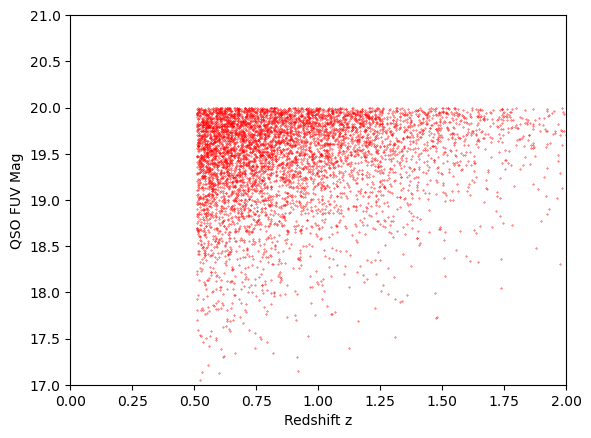

In [3]:
qsocat = qsocat[qsocat['FUV_MAG'] > 0.]
qsocat = qsocat[qsocat['FUV_MAG'] < 20.]
qsocat = qsocat[qsocat['Z'] < 2.]
qsocat = qsocat[qsocat['Z'] > 0.51]
plt.scatter(qsocat['Z'], qsocat['FUV_MAG'], marker='o', s=0.1, color='red') 
qsocat.sort('FUV_MAG') 
plt.ylim(17,21) 
plt.xlim(0, 2.)
plt.xlabel('Redshift z') 
_ = plt.ylabel('QSO FUV Mag') 

Now we will call the uvspec_exptime function that wraps the ETC to derive an exposure time for each of the QSOs in the catalog. We will compute the time it takes to reach "snrgoal" at 1150A for each QSO, in G120M only for now. Because there are so many QSOs, and computing the exptime for all of them individually will take too long, let's compute the values for a small set of magnitudes and then interpolate. 

In [4]:
def qso_exptime(qsocat, snr_goal): 
    mag_list = (np.arange(11)*0.5 + 15.)  
    exptime_list = [] 
    for mag in mag_list:  
        wave120, exp120, uvi = uvspec_exptime('EAC1', 'G120M', 'flat', mag, snr_goal, silent=False) 
        exptime_list.append(exp120[8425]/3600.)   #<---- picked 1150 A somewhat arbitrarily, 3600 converts sec to hours 
        
    qsocat['exptime_snr_'+str(snr_goal)] = np.interp(qsocat['FUV_MAG'], mag_list, exptime_list) 
    return qsocat 

In [5]:
qsocat = qso_exptime(qsocat, 10)   
qsocat = qso_exptime(qsocat, 20)  

/Users/tumlinson/anaconda3/envs/hwotools/lib/python3.12/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in /Users/tumlinson/hwotools/hwo-tools/pysynphot_data/grp/redcat/trds/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


Warning, 5 of 20000 bins contained negative fluxes; they have been set to zero.


/Users/tumlinson/anaconda3/envs/hwotools/lib/python3.12/site-packages/pysynphot/units.py:824: RuntimeWarning: divide by zero encountered in log
  return -1.085736 * N.log(arg) + ABZERO


Warning, 3590 of 20000 bins contained negative fluxes; they have been set to zero.
Warning, 293 of 2920 bins contained negative fluxes; they have been set to zero.
Setting Telescope to:  EAC1
Current SED template: 
Current grating mode: G120M (R = 30,400)
Current exposure time: 1.0 hours

Creating exposure for HWO-EAC-1 (6.0 m) with LUMOS in mode G120M
Exptime: [        nan         nan         nan ... 86.19238144 86.18959577
 86.18659628] s
Setting Telescope to:  EAC1
Current SED template: 
Current grating mode: G120M (R = 30,400)
Current exposure time: 1.0 hours

Creating exposure for HWO-EAC-1 (6.0 m) with LUMOS in mode G120M
Exptime: [         nan          nan          nan ... 136.60576499 136.60135001
 136.59659614] s
Setting Telescope to:  EAC1
Current SED template: 
Current grating mode: G120M (R = 30,400)
Current exposure time: 1.0 hours

Creating exposure for HWO-EAC-1 (6.0 m) with LUMOS in mode G120M
Exptime: [         nan          nan          nan ... 216.50566355 216.4986662

/Users/tumlinson/anaconda3/envs/hwotools/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Exptime: [         nan          nan          nan ... 861.92831998 861.9004633
 861.87046831] s
Setting Telescope to:  EAC1
Current SED template: 
Current grating mode: G120M (R = 30,400)
Current exposure time: 1.0 hours

Creating exposure for HWO-EAC-1 (6.0 m) with LUMOS in mode G120M
Exptime: [          nan           nan           nan ... 1366.06896749 1366.02481757
 1365.97727863] s
Setting Telescope to:  EAC1
Current SED template: 
Current grating mode: G120M (R = 30,400)
Current exposure time: 1.0 hours

Creating exposure for HWO-EAC-1 (6.0 m) with LUMOS in mode G120M
Exptime: [          nan           nan           nan ... 2165.08506408 2165.01509099
 2164.93974667] s
Setting Telescope to:  EAC1
Current SED template: 
Current grating mode: G120M (R = 30,400)
Current exposure time: 1.0 hours

Creating exposure for HWO-EAC-1 (6.0 m) with LUMOS in mode G120M
Exptime: [          nan           nan           nan ... 3431.45786039 3431.34696011
 3431.22754691] s
Setting Telescope to:  EAC

In [6]:
qsocat

SDSSNAME,RA,DEC,Z,PSFMAG_G,PSFMAGERR_G,FUV_MAG,NUV_MAG,gal_pathlength,exptime_snr_10,exptime_snr_20
bytes18,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64
134719.40+590232.7,206.8308563232422,59.04242706298828,0.767,15.599,0.022,16.500618,15.822352,0.16700003,0.03680383546057354,0.14721534184229415
091217.74+245037.9,138.07394409179688,24.843870162963867,0.6529,16.091,0.028,16.912584,16.185392,0.05289998,0.05452728096949665,0.2181091238779866
133602.01+172513.0,204.0083770751953,17.420297622680664,0.5519,16.073,0.015,16.96088,16.597649,0.0,0.05660505050281289,0.22642020201125157
113615.14+103430.8,174.06309509277344,10.575246810913086,0.5228,16.457,0.038,17.046543,16.482616,0.0,0.06146157258335121,0.24584629033340483
210001.24-071136.3,315.00518798828125,-7.193419933319092,0.5997,15.3,0.015,17.126225,16.390797,0.0,0.06689462609115701,0.26757850436462804
095820.94+322402.2,149.58726501464844,32.4006233215332,0.5306,16.057,0.015,17.137917,16.465614,0.0,0.06769184502075414,0.27076738008301654
075112.30+291938.3,117.80128479003906,29.327306747436523,0.9164,15.785,0.017,17.144428,16.25976,0.31640002,0.06813584264320839,0.27254337057283357
091957.60+510609.5,139.99000549316406,51.102664947509766,0.5538,16.165,0.016,17.209126,16.684599,0.0,0.07254720742166428,0.2901888296866571
093701.91+342459.8,144.25796508789062,34.41663360595703,0.916,16.459,0.014,17.303837,16.736294,0.316,0.079005070907484,0.316020283629936


In [7]:
qsocat['pathlength_per_hour_sn10'] = qsocat['gal_pathlength'] / qsocat['exptime_snr_10']
qsocat['pathlength_per_hour_sn20'] = qsocat['gal_pathlength'] / qsocat['exptime_snr_20']
qsocat.sort('pathlength_per_hour_sn10', reverse=True)
qsocat['total_exposure_time_sn10'] = qsocat['Z'] * 0.0 
qsocat['total_exposure_time_sn20'] = qsocat['Z'] * 0.0 
qsocat['total_pathlength_sn10'] = qsocat['Z'] * 0.0 
qsocat['total_pathlength_sn20'] = qsocat['Z'] * 0.0 

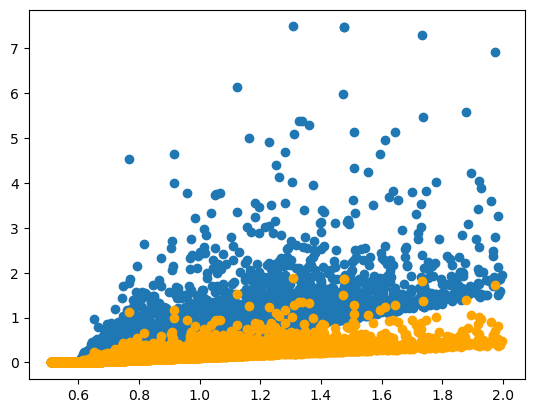

In [8]:
plt.scatter(qsocat['Z'], qsocat['pathlength_per_hour_sn10'])
plt.scatter(qsocat['Z'], qsocat['pathlength_per_hour_sn20'], color='orange')

In [9]:
total_exp_10 = 0.0 
total_exp_20 = 0.0 
total_path = 0.

for row in qsocat:    
    total_exp_10 = total_exp_10 + row['exptime_snr_10']   
    row['total_exposure_time_sn10'] = total_exp_10
    total_exp_20 = total_exp_20 + row['exptime_snr_20']   
    row['total_exposure_time_sn20'] = total_exp_20
    total_path = total_path + row['gal_pathlength']
    row['total_pathlength_sn10'] = total_path
    row['total_pathlength_sn20'] = total_path

array([ 1.47240944, 77.00223646])

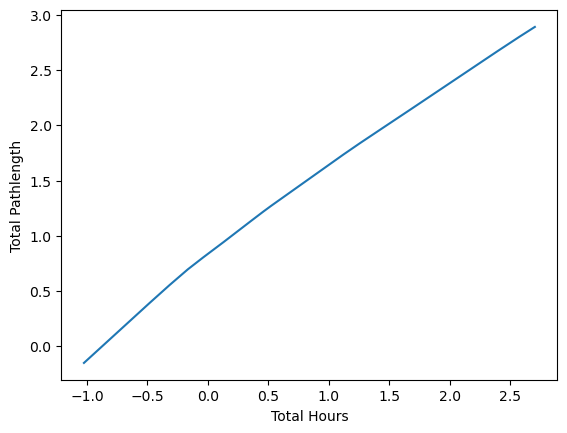

In [10]:
tt = qsocat['total_exposure_time_sn10'][0:1000]
tp = qsocat['total_pathlength_sn10'][0:1000]
plt.plot(np.log10(tt), np.log10(tp)) 
plt.xlabel('Total Hours')
_ = plt.ylabel('Total Pathlength') 
a = np.polyfit(tt, tp, deg=1)
a

(0.0, 1000.0)

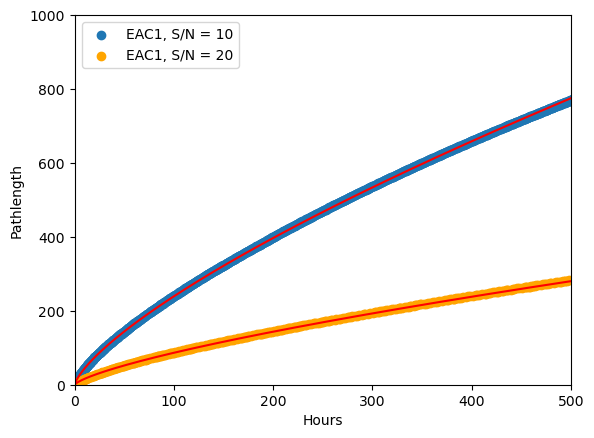

In [11]:
plt.scatter(qsocat['total_exposure_time_sn10'], qsocat['total_pathlength_sn10'], label='EAC1, S/N = 10')
plt.scatter(qsocat['total_exposure_time_sn20'], qsocat['total_pathlength_sn20'], label='EAC1, S/N = 20', color='orange')

plt.plot(tt, 8.3*tt**0.73, color='red')
plt.plot(tt, 3.*tt**0.73, color='red')
plt.legend(loc='upper left') 
plt.xlabel('Hours')
plt.ylabel('Pathlength')
plt.xlim(0,500)
plt.ylim(0,1000)